# 5 Вычисление ORB

## 5.1 Детектирование особых точек

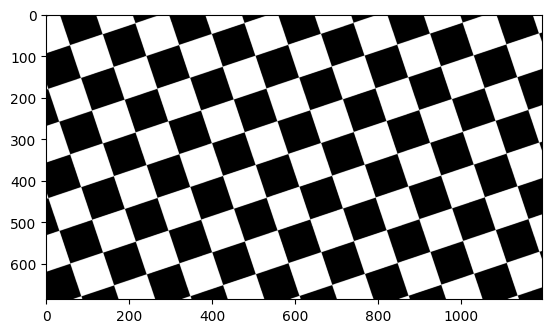

In [2]:
from typing import Union

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.pyplot import figure, imshow
import numpy as np
import numpy.typing as npt


def get_image() -> np.array:
    dir = "images/"
    image = Image.open(dir + "phpDWi1Qn.png")
    image_array = np.array(image)[:, :, :3]
    return image_array


def show_image(array: np.array, mode: Union[str, None] = 'Greys'):
    figure()
    imshow(array, cmap=mode)


def get_halftone_image() -> np.array:
    image_array = get_image()
    mean = np.mean(image_array, axis=2, dtype=int)
    return mean

show_image(get_halftone_image())

In [3]:
def get_gaussian(size: int, sigma: float = .84089642) -> npt.NDArray[float]:
    pad = size // 2

    K = np.zeros((size, size), np.float64)
    for x in range(-pad, -pad + size):
        for y in range(-pad, -pad + size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()
    return K

In [4]:
def extend_image(img, size: int) -> npt.NDArray[npt.NDArray[int]]:
    h, w = img.shape
    out = np.zeros((h + size * 2, w + size * 2), dtype=img.dtype)
    out[size:size + h, size: size + w] = img
    for i in range(size):
        out[size:size + h, i] = img[:, 0]
        out[size:size + h, size + w + i] = img[:, w - 1]
    for i in range(size):
        out[size - i - 1, :] = out[size, :]
        out[size + h + i, :] = out[size + h - 1, :]
    return out

In [5]:
def get_list_circle_bresenham(area: npt.NDArray[npt.NDArray[int]], r: int = 3) -> tuple[int]:
    return (area[0, 3], area[0, 4], area[1, 5], area[2, 6], area[3, 6], area[4, 6], area[5, 5],
            area[6, 4], area[6, 3], area[6, 2], area[5, 1], area[4, 0], area[3, 0], area[2, 0],
            area[1, 1], area[0, 2])

In [6]:
def is_special(points: tuple[int], p: int, t: int) -> bool:
    greater = points[0] > p + t, points[4] > p + t, points[8] > p + t, points[12] > p + t
    less = points[0] < p + t, points[4] < p + t, points[8] < p + t, points[12] < p + t
    if sum(greater) < 3 and sum(less) < 3:
        return False

    gt = lt = False
    cnt = 0
    for i in range(len(points)):
        if points[i] < p + t:
            if gt:
                gt = False
            if not lt:
                lt = True
                cnt = 0
            cnt += 1
        elif points[i] > p + t:
            if lt:
                lt = False
            if not gt:
                gt = True
                cnt = 0
            cnt += 1
        else:
            cnt = 0
        if cnt == 12:
            return True
        if len(points) - i - 1 + cnt < 12:
            return False
    return False

In [7]:
def fast(img, r: int, t: int) -> npt.NDArray[bool]:
    extended_image = extend_image(img, r)
    h, w = img.shape
    marks = np.zeros((h, w), dtype=bool)
    for i in range(h):
        for j in range(w):
            i_end = i + r * 2 + 1
            if i_end == extended_image.shape[0]:
                i_end = None
            j_end = j + r * 2 + 1
            if j_end == extended_image.shape[1]:
                j_end = None
            points = get_list_circle_bresenham(extended_image[i: i_end, j: j_end])
            if is_special(points, img[i, j], t):
                marks[i, j] = True
    return marks

In [8]:
def harris(img: npt.NDArray[int], candidates: npt.NDArray[bool], k: float = 0.05) -> npt.NDArray[float]:
    gaussian = get_gaussian(5)
    size = 2
    extended_img = extend_image(img, size)
    gradients = filter_sobel(extended_img)
    result = np.zeros(img.shape, dtype=float)
    Ix = gradients[:, :, 0]
    Iy = gradients[:, :, 1]
    candidates_coords = np.argwhere(candidates)

    for i, j in candidates_coords:
        i_end = i + size * 2 + 1
        if i_end >= extended_img.shape[0]:
            i_end = None
        j_end = j + size * 2 + 1
        if j_end >= extended_img.shape[1]:
            j_end = None
        Wxx = Ix[i:i_end, j:j_end] ** 2 * gaussian
        Wxy = Ix[i:i_end, j:j_end] * Iy[i:i_end, j:j_end] * gaussian
        Wyy = Iy[i:i_end, j:j_end] ** 2 * gaussian
        M = np.array([
            [np.sum(Wxx), np.sum(Wxy)],
            [np.sum(Wxy), np.sum(Wyy)]
        ], dtype=float)
        R = np.linalg.det(M) - k * np.matrix.trace(M) ** 2
        result[i, j] = R

    return result

In [9]:
def filter_sobel(image) -> npt.NDArray[list[tuple[int, int]]]:
    H, W = image.shape

    out = np.zeros((H + 2, W + 2, 2), np.float64)
    out[1: 1 + H, 1: 1 + W, 0] = image.copy().astype(np.float64)
    out[0, 0, 0] = out[1, 1, 0]
    out[-1, 0, 0] = out[-2, 1, 0]
    out[0, -1, 0] = out[1, -2, 0]
    out[-1, -1, 0] = out[-2, -2, 0]
    out[1: 1 + H, 0, 0] = out[1: 1 + H, 1, 0]
    out[1: 1 + H, -1, 0] = out[1: 1 + H, -2, 0]
    out[0, 1: 1 + W, 0] = out[1, 1: 1 + W, 0]
    out[-1, 1: 1 + W, 0] = out[-2, 1: 1 + W, 0]

    Mx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
        dtype=int
    )
    My = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ],
        dtype=int
    )
    tmp = out.copy()

    # Ix, Iy
    for y in range(H):
        for x in range(W):
            out[1 + y, 1 + x] = (np.sum(Mx * tmp[y: y + 3, x: x + 3, 0]), np.sum(My * tmp[y: y + 3, x: x + 3, 0]))
    return out[1: 1 + H, 1: 1 + W]

In [10]:
def non_maximum_suppression(harris_values: npt.NDArray[float], offset: int = 3):
    # h, w = harris_values.shape
    # for i in range(h - offset + 1):
    #     for j in range(w - offset + 1):
    #         i_end = i + offset
    #         if i_end >= h:
    #             i_end = None
    #         j_end = j + offset
    #         if j_end >= w:
    #             j_end = None
    #         window = harris_values[i:i_end, j:j_end]
    #         lt_max = window < np.max(window)
    #         window[lt_max] = 0
    #         harris_values[i:i_end, j:j_end] = window
    max_point = np.max(harris_values)
    special_points = harris_values > 0.01 * max_point
    harris_values[~special_points] = 0

In [11]:
image = get_halftone_image()

In [12]:
r = 3
candidates = fast(image, r, 20)

In [13]:
special_points = harris(image, candidates, 0.04)

In [14]:
non_maximum_suppression(special_points)

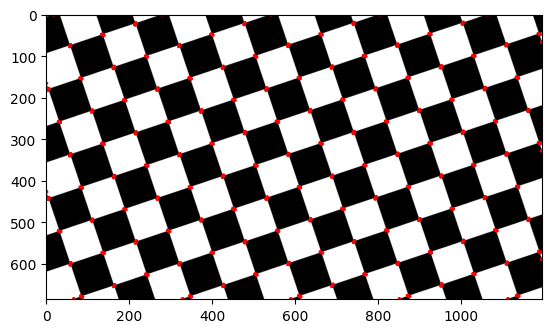

In [15]:
def draw_special_points(img_source, points: npt.NDArray[npt.NDArray[float]]):
    figure()
    plt.gray()
    h, w = points.shape
    # max_point = np.max(points)
    for i in range(h):
        for j in range(w):
            # if points[i, j] > 0.01 * max_point:
            if points[i, j]:
                c = Circle((j, i), radius=2, color='red')
                plt.gca().add_artist(c)
    imshow(img_source)

draw_special_points(image, special_points)

In [ ]:
def calculate_orientation(points: npt.NDArray[float], img: npt.NDArray[int]) -> dict[tuple[int, int], float]:
    size = 31
    extended_image = extend_image(img, size)
    orientations = {}
    h, w = extended_image.shape
    for i, j in np.argwhere(points):
        i_end = i + size * 2 + 1
        if i_end >= h:
            i_end = None
        j_end = j + size * 2 + 1
        if j_end >= w:
            j_end = None
        window = extended_image[i:i_end, j:j_end]
        window_coords = np.argwhere(window >= 0)
        window_coords -= size
        m = window_coords * window
        m01 = np.sum(m[:, :, 0])
        m10 = np.sum(m[:, :, 1])
        theta = np.arctan2(m01, m10)
        orientations[(i, j)] = theta
    
    return orientations

In [ ]:
special_points_orientations = calculate_orientation(special_points, image)

## 5.2 Построение дескриптора

In [ ]:
def image_filter(K_size, sigma, im):
    H, W = im.shape
    
    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad: pad + H, pad: pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y: y + K_size, x: x + K_size])
    out = np.clip(out, 0, 255).astype(int)
    return out[pad: pad + H, pad: pad + W]

In [ ]:
def get_descryptor_angle(point_angle: float) -> float:
    imin = 0
    min_diff = 'inf'
    for i, angle in enumerate(np.arange(0, 2 * np.pi / 30, 30)):
        abs_diff = abs(angle - point_angle)
        if abs_diff < min_diff:
            imin = i
            min_diff = abs_diff
    return 2 * np.pi / 30 * i

In [ ]:
def special_points_descryptor(image: npt.NDArray[int], orientations: dict) -> dict[tuple[int, int], float]:
    size = 31
    pair_count = 256
    extended_image = extend_image(image, size // 2)
    orientations = {}
    h, w = extended_image.shape
    for i, j in orientations:
        i_end = i + size
        if i_end >= h:
            i_end = None
        j_end = j + size
        if j_end >= w:
            j_end = None
        """
        TODO: *
            1. Найти 256 пар точек
            2. Повернуть все точки на угол через матрицу
                MRot = Rotation.from_euler('x', [np.pi/2]).as_matrix()
            3. Пройтись по парам точек и сравнить интенсивность
            4. Добавлять результат как 1 или 0 в строку
            5. В словарь добавляем строку (дескриптор)
            6. Выход
        """
        window = extended_image[i:i_end, j:j_end]
        window_coords = np.argwhere(window >= 0)
        random_coords = np.random.shuffle(window_coords)[:pair_count * 2]
        


In [ ]:
blurred_image = image_filter(3, 1.2, image)
desctyptor = special_points_descryptor(blurred_image, special_points, special_points_orientations)